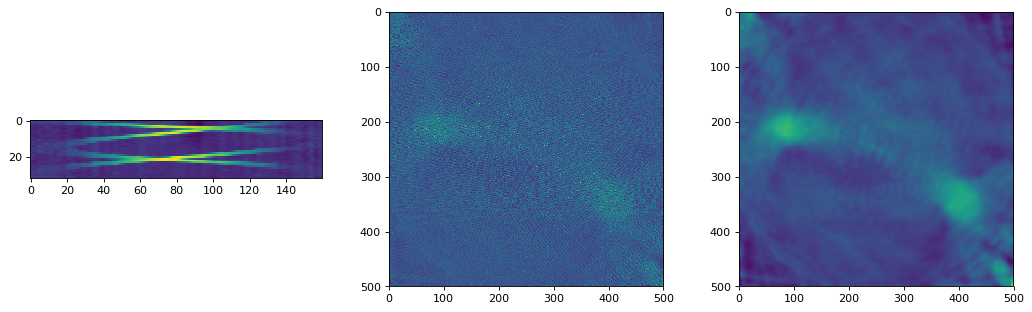

In [2]:
# Import required libraries
from image_util import *
import skimage.filters
from matplotlib import pyplot as plt
import cairocffi as cairo
import math, random
import numpy as np
import pandas as pd
from IPython.display import Image
from scipy.interpolate import interp1d
import astra

%matplotlib inline

# First, set constants and load data

# Constants
dist_d = 70/50 #(70mm)
dist_e = 95/50 #(95mm)
nviews = 32
ndetectors = 160
nvdetectors = 160 # Can optionally simulate having fewer detectors by changing this number

# Data
bb = pd.read_csv('12Aug_BASE_two_pens.csv')
br = pd.read_csv('12Aug_R_two_pens.csv')
readings = np.asarray(br)
base = np.asarray(bb).T
for r in range(len(readings)):
    readings[r] = readings[r]-base

# Defining distances in pixels
IMSIZE = 500
R = dist_d*IMSIZE/2
D = dist_e*IMSIZE/2

# Transforming from a round fan-beam to a fan-flat projection (See diagram)
beta = np.linspace(0, math.pi, 160)
alpha = np.asarray([R*math.sin(b-math.pi/2)/(R**2 + D**2)**0.5 for b in beta])
tau = np.asarray([(R+D)*math.tan(a) for a in alpha])

readings2 = []
tau_new = np.linspace(-(max(tau)/2), 1.3*max(tau)/2, nvdetectors) # Can change bounds. GOod to stick within max

for r in readings:
    f = interp1d(tau, r, kind='cubic') # Can change to linear
    readings2.append(f(tau_new))


# Reconstructing

# Defining the geometry in ASTRA
vol_geom = astra.create_vol_geom(IMSIZE, IMSIZE)
angles = np.linspace(0,2*math.pi,nviews);
d_size = (tau[-1]-tau[0])/nvdetectors
proj_geom= astra.create_proj_geom('fanflat', d_size, nvdetectors, angles, D, R);
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)
sinogram_id = astra.data2d.create('-sino', proj_geom, np.asarray(readings2))

# Plotting sinogram - new (transformed) set of readings
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
ax1 = plt.subplot(2, 3, 1)
ax1.imshow(readings2) #<< Set title

# Doing the reconstruction, in this case with the SIRT algorithm (can change to 'FBP')
rec_id = astra.data2d.create('-vol', vol_geom)

cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

astra.algorithm.run(alg_id, 20)

# Get the result
rec = astra.data2d.get(rec_id)
ax2 = plt.subplot(2, 3, 2)
ax2.imshow(rec)
norm_rec = rec/np.amax(rec)
blurred = skimage.filters.gaussian(norm_rec, 3)
ax3 = plt.subplot(2, 3, 3)
ax3.imshow(blurred)

plt.savefig('reconstruction.png')


# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)